# Flooding Spring 2022

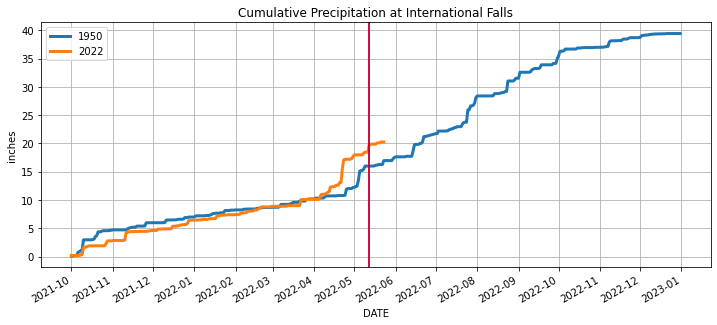

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as datetime
import pandas as pd

def read_weather_data(filename):
    df = pd.read_csv(filename)
    df = df[df["STATION"]=="USW00014918"]
    df["DATE"] = pd.to_datetime(df["DATE"])
    df["Q_prcp"] = df["PRCP"].cumsum()
    return df

weather_1950 = read_weather_data("../../data/flooding_2022/2984544.csv")
weather_1950["DATE"] = weather_1950["DATE"] + pd.Timedelta(days=72*365.25)

weather_2022 = read_weather_data("../../data/flooding_2022/2985131.csv")

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
weather_1950.plot(ax=ax, x="DATE", y="Q_prcp", lw=3)
weather_2022.plot(ax=ax, x="DATE", y="Q_prcp", lw=3, grid=True, ylabel="inches")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.legend(["1950", "2022"])

ax.set_title("Cumulative Precipitation at International Falls")

# ice out dates
ax.axvline(datetime.datetime(2022, 5, 22-10), color='b')
ax.axvline(datetime.datetime(2022, 5, 12), color='r')


## Rainy Lake 2022

<AxesSubplot:xlabel='DATE'>

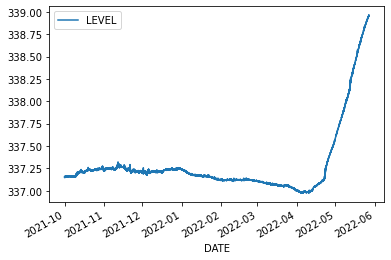

In [4]:
import pandas as pd

rl_2022 = pd.read_csv("../../data/flooding_2022/05PB007_HG_May-27-2022_06_45_14PM.csv", skiprows=8)
rl_2022["DATE"] = pd.to_datetime(rl_2022["Date (EST)"])
rl_2022["LEVEL"] = rl_2022["Value (m)"]
rl_2022.plot(x="DATE", y="LEVEL")

## Historical Rainy Lake Levels

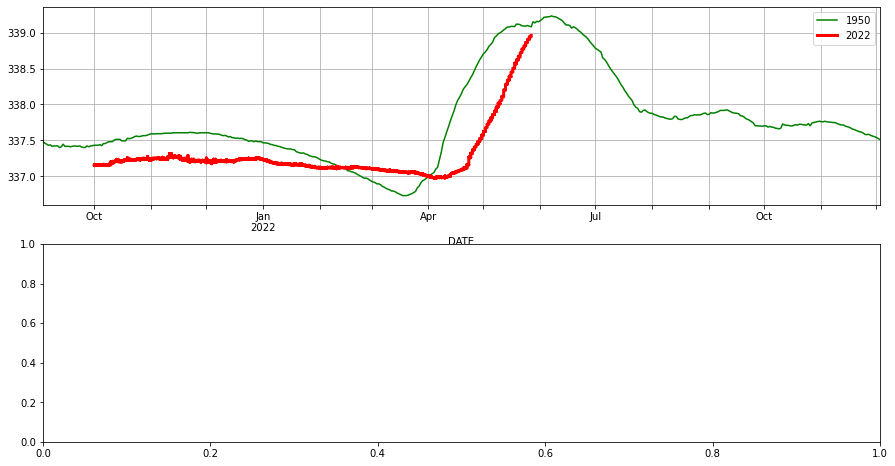

In [32]:
import sqlite3
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

class Hydat():
    
    def __init__(self, db="../../data/HYDAT/Hydat.sqlite3"):
        self.db = db
        self.con = sqlite3.connect(db)
    
    def get_tables(self):
        cur = self.con.cursor()
        cur.execute('SELECT name from sqlite_master where type= "table"')
        return cur.fetchall()
    
    def get_stations(self, lat=None, lng=None):
        sql = "SELECT * from STATIONS"
        if lat:
            sql += f" WHERE LATITUDE >= {lat[0]} AND LATITUDE <= {lat[1]}"
        if lng:
            sql += f" AND LONGITUDE >= {lng[0]} AND LONGITUDE <= {lng[1]}"
        stations = pd.read_sql_query(sql, self.con)
        return stations
    
    def get_levels(self, station_number, start=None, end=None):
        sql = f"SELECT * from DLY_LEVELS WHERE STATION_NUMBER = '{station_number}'"
        if start:
            sql += f" AND YEAR >= {start}"
        if end:
            sql += f" AND YEAR <= {end}"
        df = pd.read_sql_query(sql, self.con)
        ts = dict()
        for k in df.index:
            mo = str(df.loc[k, 'MONTH'])
            yr = str(df.loc[k, 'YEAR'])
            for n in range(1, df.loc[k,'NO_DAYS'] + 1):
                date = pd.to_datetime('/'.join([mo, str(n), yr]))
                ts[date] = df.loc[k, 'LEVEL' + str(n)]  
        ts = pd.Series(ts)
        #drop initial and terminal null entries
        j = 0
        while j < len(ts.index) and pd.isnull(ts[j]):
            j += 1
        k = len(ts.index) - 1
        while k >= j and pd.isnull(ts[k]):
            k += -1
        return ts[j:k+1]
    
    def get_flows(self, station_number, start=None, end=None):
        sql = f"SELECT * from DLY_FLOWS WHERE STATION_NUMBER = '{station_number}'"
        if start:
            sql += f" AND YEAR >= {start}"
        if end:
            sql += f" AND YEAR <= {end}"
        df = pd.read_sql_query(sql, self.con)
        ts = dict()
        for k in df.index:
            mo = str(df.loc[k, 'MONTH'])
            yr = str(df.loc[k, 'YEAR'])
            for n in range(1, df.loc[k,'NO_DAYS'] + 1):
                date = pd.to_datetime('/'.join([mo, str(n), yr]))
                ts[date] = df.loc[k,'FLOW' + str(n)]  
        ts = pd.Series(ts)
        #drop initial and terminal null entries
        j = 0
        while j < len(ts.index) and pd.isnull(ts[j]):
            j += 1
        k = len(ts.index) - 1
        while k >= j and pd.isnull(ts[k]):
            k += -1
        return ts[j:k+1]
        
hydat = Hydat()
rl_1950 = pd.DataFrame(hydat.get_levels("05PB007", start=1949, end=1950))
rl_1950 = rl_1950[rl_1950.index >= datetime.datetime(1949, 10, 1)]
rl_1950.index = rl_1950.index + pd.Timedelta(days=72*365 - 10)

fig, ax = plt.subplots(2, 1, figsize=(15, 8))
rl_1950.plot(ax=ax[0], color='g')
rl_2022.plot(ax=ax[0], x="DATE", y="LEVEL", color='r', lw=3)
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[0].legend(['1950', '2022'])
ax[0].grid(True)

<AxesSubplot:>

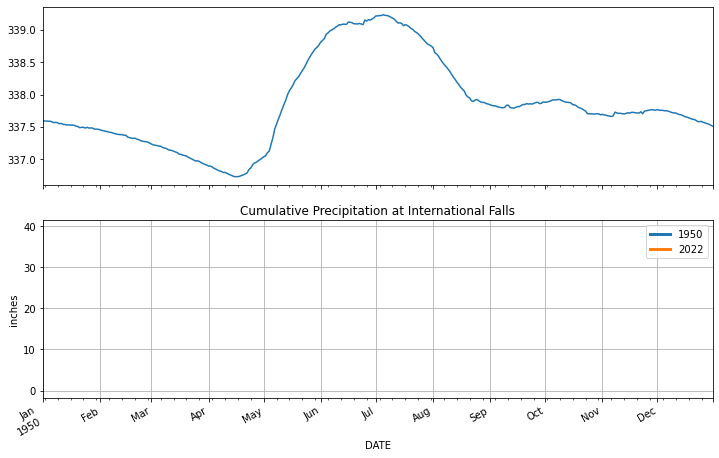

In [105]:

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
weather_1950.plot(ax=ax[1], x="DATE", y="Q_prcp", lw=3)
weather_2022.plot(ax=ax[1], x="DATE", y="Q_prcp", lw=3, grid=True, ylabel="inches")

ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax[1].legend(["1950", "2022"])

ax[1].set_title("Cumulative Precipitation at International Falls")

# ice out dates
ax[1].axvline(datetime.datetime(2022, 5, 22-10), color='b')
ax[1].axvline(datetime.datetime(2022, 5, 12), color='r')

rl_1950 = hydat.get_levels("05PB007", start=1950, end=1950)
print
rl_1950.plot(ax=ax[0])
